# Energy consumption prediction using LSTM/GRU in PyTorch

In this notebook, we'll be using GRU and LSTM models for a time series prediction task and we will compare the performance of the GRU model against an LSTM model as well. The dataset that we will be using is the Hourly Energy Consumption dataset which can be found on [Kaggle](https://www.kaggle.com/robikscube/hourly-energy-consumption). The dataset contains power consumption data across different regions around the United States recorded on an hourly basis.

Link to the GitHub repository: https://github.com/amirmasoudsfd/energy-consumption-prediction.

The goal of this implementation is to **create a model that can accurately predict the energy usage in the next hour** given historical usage data. We will be using both the GRU and LSTM model to train on a set of historical data and evaluate both models on an unseen test set. To do so, we'll start with feature selection, data-preprocessing, followed by defining, training and eventually evaluating the models.

We will use the PyTorch library to implement both types of models along with other common Python libraries used in data analytics.

## Important Points:
* Basic knowledge of Deep Learning, Python, Numpy, Pandas, and Pytorch is required.
* We will use LSTM/GRU units as black boxes. Internals are explained here: 

    * https://colah.github.io/posts/2015-08-Understanding-LSTMs/

    * http://www.sefidian.com/2020/01/30/gated-recurrent-unit-gru-with-pytorch/

* No need to GPU. For high speed execution I recommend you to use [GOOGLE COLAB](https://colab.research.google.com) if your hardware is not powerful enough.

## GRU/LSTM cells

* Long Short-Term Memory networks (LSTMs) have great memories and can remember information which the vanilla RNN is unable to!

* The Gated Recurrent Unit (GRU) is the younger sibling of the more popular Long Short-Term Memory (LSTM) network, and also a type of Recurrent Neural Network (RNN). Just like its sibling, GRUs are able to effectively retain long-term dependencies in sequential data. And additionally, they can address the “short-term memory” issue plaguing vanilla RNNs.

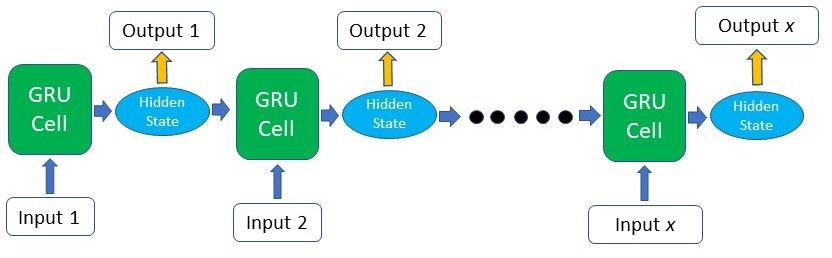

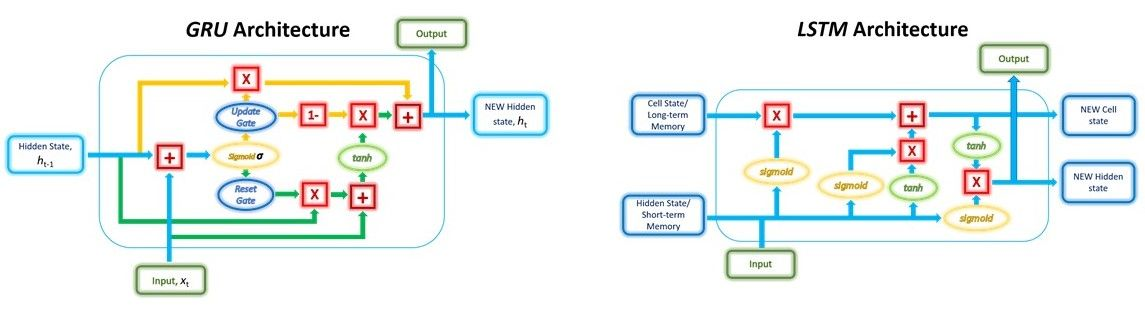

## The ML Pipeline

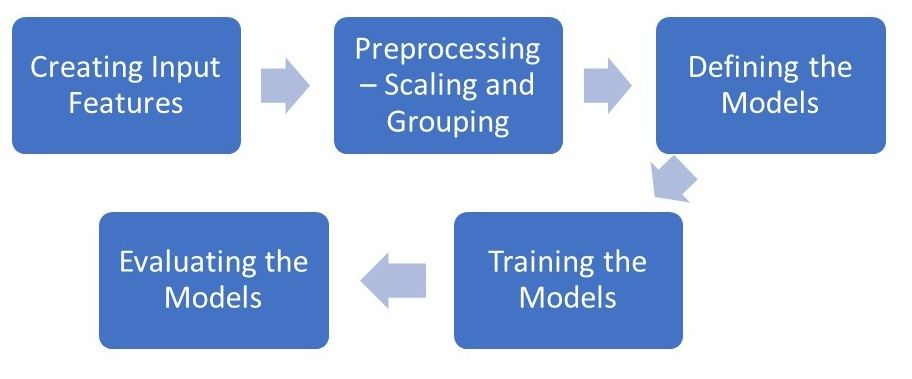

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import math
from tqdm.notebook import tqdm as tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

In [2]:
print(torch.__version__)

2.1.2


## Exploratory Data Analysis (EDA)

In [3]:
# Define data root directory
data_dir = "/kaggle/input/energy-consumption-prediction/data/"
print(os.listdir(data_dir))

['DOM_hourly.csv', 'EKPC_hourly.csv', 'DUQ_hourly.csv', 'DAYTON_hourly.csv', 'PJME_hourly.csv', 'PJM_Load_hourly.csv', 'NI_hourly.csv', 'FE_hourly.csv', 'COMED_hourly.csv', 'AEP_hourly.csv', 'DEOK_hourly.csv', 'PJMW_hourly.csv']


In [4]:
pd.read_csv(os.path.join(data_dir, "DEOK_hourly.csv")).head()

,Datetime,DEOK_MW
0,2012-12-31 01:00:00,2945.0
1,2012-12-31 02:00:00,2868.0
2,2012-12-31 03:00:00,2812.0
3,2012-12-31 04:00:00,2812.0
4,2012-12-31 05:00:00,2860.0


We have a total of **12** *.csv* files containing hourly energy trend data (*'est_hourly.paruqet'* and *'pjm_hourly_est.csv'* are not used). In our next step, we will be reading these files and pre-processing these data in this order:
- Getting the time data of each individual time step and generalizing them
    - Hour of the day *i.e. 0-23*
    - Day of the week *i.e. 1-7*
    - Month *i.e. 1-12*
    - Day of the year *i.e. 1-365*
    
    
- Scale the data to values between 0 and 1
    - Algorithms tend to perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed
    - Scaling preserves the shape of the original distribution and doesn't reduce the importance of outliers
    
    
- Group the data into sequences to be used as inputs to the model and store their corresponding labels
    - The **sequence length** or **window_size period** is the number of data points in history that the model will use to make the prediction
    - The label will be the next data point in time after the last one in the input sequence
    

- The inputs and labels will then be split into training and test sets

## Create training instances by moving sliding window

In [5]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    """

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((len(data) - window_size, window_size, len(inputs_cols_indices)))
    labels = np.zeros(len(data) - window_size)

    for i in range(window_size, len(data)):
        inputs[i - window_size] = data[i - window_size : i, inputs_cols_indices]
        labels[i - window_size] = data[i, label_col_index]
    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)
    print(inputs.shape, labels.shape)

    return inputs, labels

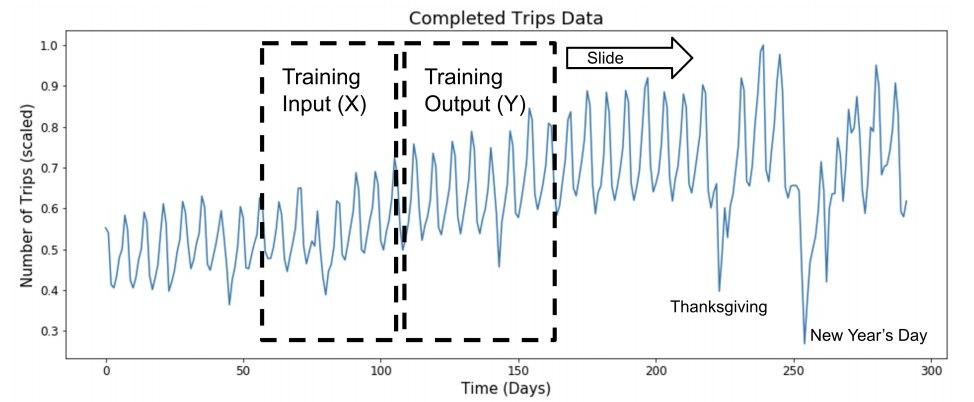

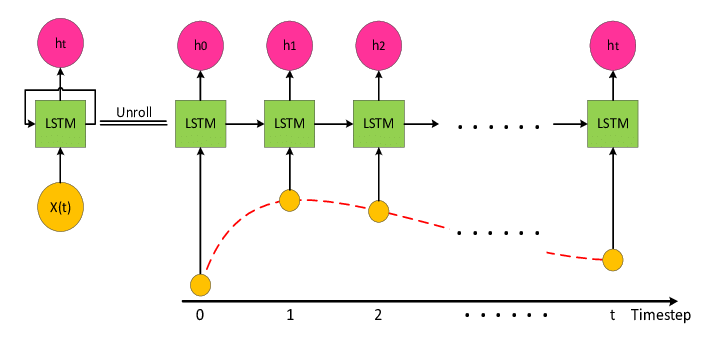

## Integrate files to build the training set
To speed things up, I will only be using `num_files_for_dataset` .csv files for creating my dataset. Feel free to run it yourself with the entire dataset if you have the time and computing capacity. 

In [6]:
label_col_index = 0  # consumption as label to predict
inputs_cols_indices = range(
    5
)  # use (consumption, hour, dayofweek, month, dayofyear) columns as features

# Define window_size period and split inputs/labels
window_size = 90

# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}

train_x = []
test_x = {}
test_y = {}

# Skipping the files we're not using
processing_files = [
    file for file in os.listdir(data_dir) if os.path.splitext(file)[1] == ".csv"
]

num_files_for_dataset = 5

for file in tqdm_notebook(processing_files[:num_files_for_dataset]):
    print(f"Processing {file} ...")
    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(os.path.join(data_dir, file), parse_dates=["Datetime"])

    # Processing the time data into suitable input formats
    df["hour"] = df.apply(lambda x: x["Datetime"].hour, axis=1)
    df["dayofweek"] = df.apply(lambda x: x["Datetime"].dayofweek, axis=1)
    df["month"] = df.apply(lambda x: x["Datetime"].month, axis=1)
    df["dayofyear"] = df.apply(lambda x: x["Datetime"].dayofyear, axis=1)
    df = df.sort_values("Datetime").drop("Datetime", axis=1)

    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)

    # Obtaining the scaler for the labels(usage data) so that output can be
    # re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:, label_col_index].values.reshape(-1, 1))
    label_scalers[file] = label_sc

    # Move the window
    inputs, labels = move_sliding_window(
        data,
        window_size,
        inputs_cols_indices=inputs_cols_indices,
        label_col_index=label_col_index,
    )

    # CONCAT created instances from all .csv files.
    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1 * len(inputs))
    if len(train_x) == 0:  # first iteration
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x, inputs[:-test_portion]))
        train_y = np.concatenate((train_y, labels[:-test_portion]))
    test_x[file] = inputs[-test_portion:]
    test_y[file] = labels[-test_portion:]

  0%|          | 0/5 [00:00<?, ?it/s]

Processing DOM_hourly.csv ...
(116099, 90, 5) (116099, 1)
Processing EKPC_hourly.csv ...
(45244, 90, 5) (45244, 1)
Processing DUQ_hourly.csv ...
(118978, 90, 5) (118978, 1)
Processing DAYTON_hourly.csv ...
(121185, 90, 5) (121185, 1)
Processing PJME_hourly.csv ...
(145276, 90, 5) (145276, 1)


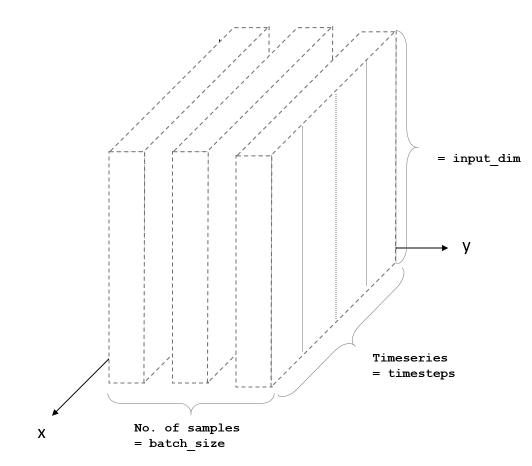!

## What have we made?

In [7]:
# train_x.shape, test_x["DEOK_hourly.csv"].shape

## Pytorch data loaders/generators

To improve the speed of our training, we can process the data in batches so that the model does not need to update its weights as frequently. The `TensorDataset` and `DataLoader` classes are useful for splitting our data into batches and shuffling them.

In [8]:
batch_size = 1024

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))

# Drop the last incomplete batch
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=True
)

In [9]:
print(
    f"Train Size: {train_x.shape}, Batch Size: {batch_size}, # of iterations per epoch: {int(train_x.shape[0]/batch_size)}"
)

Train Size: (492107, 90, 5), Batch Size: 1024, # of iterations per epoch: 480


In [10]:
# release some memory
del train_x, train_y

We can also check if we have any GPUs to speed up our training time by many folds. If you’re using "https://colab.research.google.com/" with GPU to run this code, the training time will be significantly reduced.

In [11]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")

GPU is available


Next, we'll be defining the structure of the GRU and LSTM models. Both models have the same structure, with the only difference being the **recurrent layer** (GRU/LSTM) and the initializing of the hidden state. The hidden state for the LSTM is a tuple containing both the **cell state** and the **hidden state**, whereas the **GRU only has a single hidden state**. 
Please refer to official PyTorch documentation to get familiar with GRU and LSTM interfaces in PyTorch:

- https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
- https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM

You can also detailed tutorials about Recurrent Neural Networks on my [Blog](http://www.sefidian.com/archives/) and [Github](https://github.com/iamirmasoud).

# LSTM 
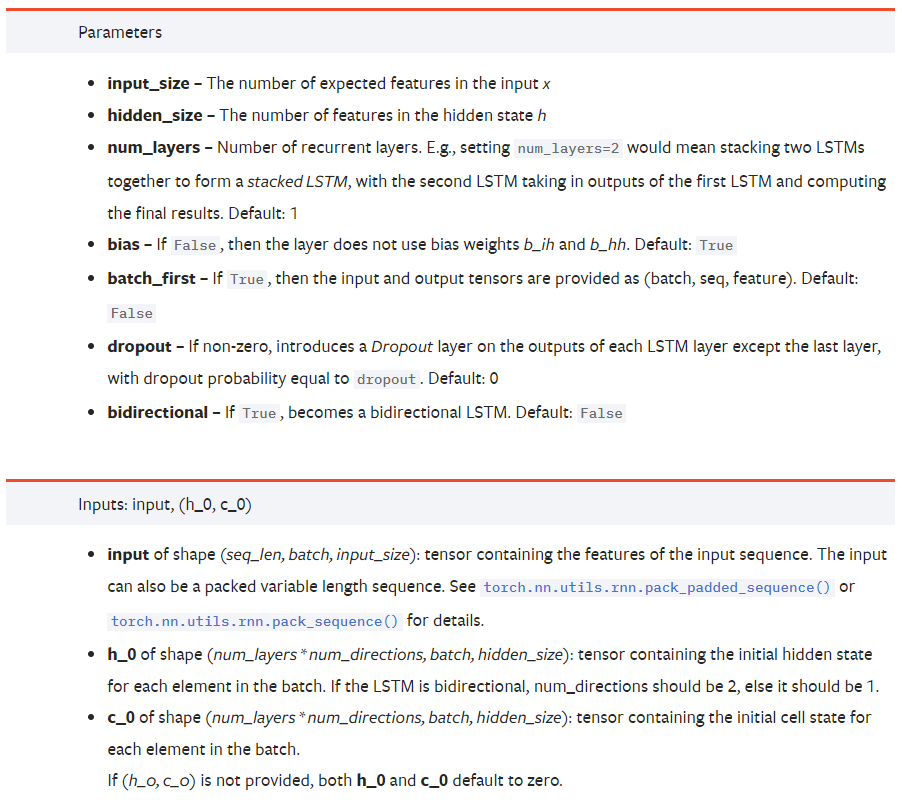!
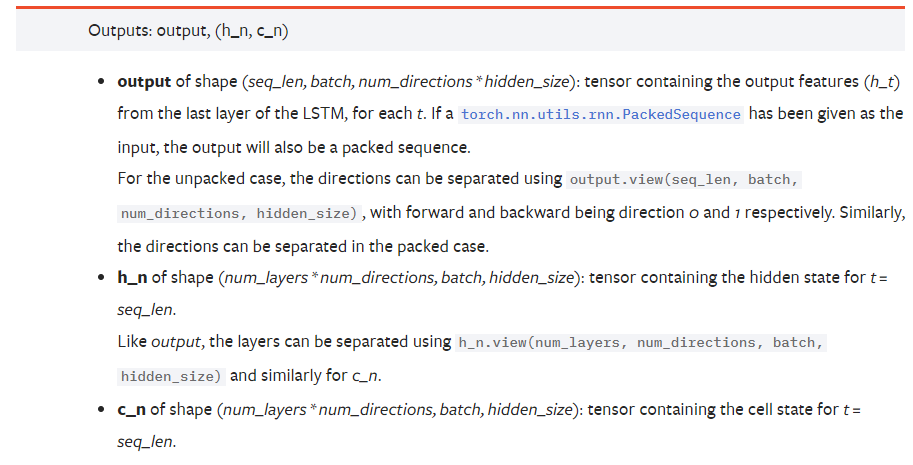!

# GRU 
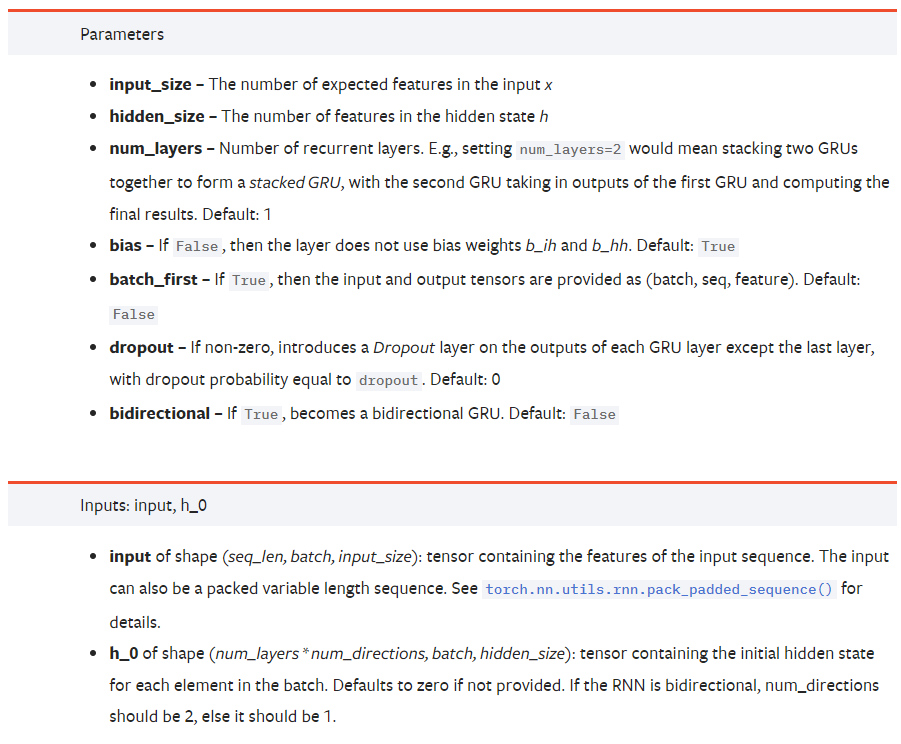!
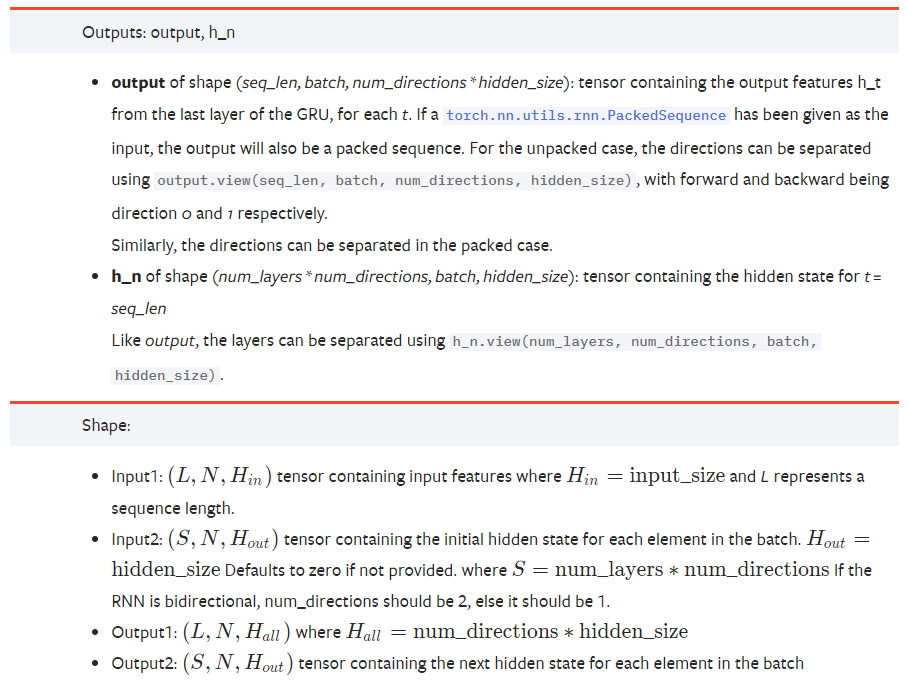!

In [12]:
# KANLinear class definition as provided
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3, scale_noise=0.1, scale_base=1.0, scale_spline=1.0, enable_standalone_scale_spline=True, base_activation=nn.SiLU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)
        splines = self.b_splines(x).permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff).permute(1, 0, 2)
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[torch.linspace(0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device)]
        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (torch.arange(self.grid_size + 1, dtype=torch.float32, device=x.device).unsqueeze(1) * uniform_step + x_sorted[0] - margin)
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat([grid[:1] - uniform_step * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1), grid, grid[-1:] + uniform_step * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1)], dim=0)
        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy



In [13]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        # print(out[:, -1].shape, h.shape)
        # select hidden state of last timestamp (t=90) (1024, 256)
        out = self.fc(self.relu(out[:, -1]))  # out[:, -1, :]
        # print(out.shape) # (1024, 1)
        return out, h

    def init_hidden(self, batch_size):
        # Initialze h_0 with zeros
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        )
        return hidden
    

class GRUNetKAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNetKAN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = KANLinear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        # print(out[:, -1].shape, h.shape)
        # select hidden state of last timestamp (t=90) (1024, 256)
        out = self.fc(self.relu(out[:, -1]))  # out[:, -1, :]
        # print(out.shape) # (1024, 1)
        return out, h

    def init_hidden(self, batch_size):
        # Initialze h_0 with zeros
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        )
        return hidden

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialze h_0, c_0 with zeros
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim)
            .zero_()
            .to(device),  # h_0
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden
    
class LSTMNetKAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNetKAN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob
        )
        self.fc = KANLinear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:, -1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        # Initialze h_0, c_0 with zeros
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim)
            .zero_()
            .to(device),  # h_0
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

In [14]:
def train(
    train_loader,
    learn_rate,
    hidden_dim=256,
    n_layers=2,
    n_epochs=5,
    model_type="GRU",
    print_every=100,
):

    input_dim = next(iter(train_loader))[0].shape[2]  # 5

    # Batch generator (train_data, train_label)
    # print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape) # torch.Size([1024, 90, 5]) torch.Size([1024, 1])

    output_dim = 1

    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    elif model_type == "GRUKAN":
        model = GRUNetKAN(input_dim, hidden_dim, output_dim, n_layers)
    elif model_type == "LSTM":
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNetKAN(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []

    # Start training loop
    for epoch in range(1, n_epochs + 1):
        start_time = time.process_time()
        h = model.init_hidden(batch_size)
        avg_loss = 0.0
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            elif model_type == "GRUKAN":
                h = h.data
            # Unpcak both h_0 and c_0
            elif model_type == "LSTM":
                h = tuple([e.data for e in h])
            elif model_type == "LSTMKAN":
                h = tuple([e.data for e in h])

            # Set the gradients to zero before starting to do backpropragation because
            # PyTorch accumulates the gradients on subsequent backward passes
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())

            # Perform backpropragation
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
            if counter % print_every == 0:
                print(
                    f"Epoch {epoch} - Step: {counter}/{len(train_loader)} - Average Loss for Epoch: {avg_loss/counter}"
                )
        current_time = time.process_time()

        print(
            f"Epoch {epoch}/{n_epochs} Done, Total Loss: {avg_loss/len(train_loader)}"
        )

        print(f"Time Elapsed for Epoch: {current_time-start_time} seconds")

        epoch_times.append(current_time - start_time)

    print(f"Total Training Time: {sum(epoch_times)} seconds")
    return model

## Training the GRU model

In [15]:
# seq_len = 90  # (timestamps)
n_hidden = 256
n_layers = 2
n_epochs = 20
print_every = 100
lr = 0.001
gru_model = train(
    train_loader,
    learn_rate=lr, 
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="GRU",
    print_every=print_every,
)

Starting Training of GRU model
Epoch 1 - Step: 100/480 - Average Loss for Epoch: 0.009568244351539761
Epoch 1 - Step: 200/480 - Average Loss for Epoch: 0.005375958156946581
Epoch 1 - Step: 300/480 - Average Loss for Epoch: 0.003835455959973236
Epoch 1 - Step: 400/480 - Average Loss for Epoch: 0.0030128903230070138
Epoch 1/20 Done, Total Loss: 0.002589438178195754
Time Elapsed for Epoch: 38.85943229800001 seconds
Epoch 2 - Step: 100/480 - Average Loss for Epoch: 0.00038155274814926087
Epoch 2 - Step: 200/480 - Average Loss for Epoch: 0.0003538181980547961
Epoch 2 - Step: 300/480 - Average Loss for Epoch: 0.0003349182425881736
Epoch 2 - Step: 400/480 - Average Loss for Epoch: 0.0003194932241967763
Epoch 2/20 Done, Total Loss: 0.00030787236370694395
Time Elapsed for Epoch: 38.609484736 seconds
Epoch 3 - Step: 100/480 - Average Loss for Epoch: 0.00023420272045768798
Epoch 3 - Step: 200/480 - Average Loss for Epoch: 0.0002312220027670264
Epoch 3 - Step: 300/480 - Average Loss for Epoch: 0.0

## Save the GRU model

In [16]:
!ls /kaggle/                                     

input  lib  working


In [17]:
torch.save(gru_model.state_dict(), "/kaggle/gru_model.pt")

## Training the GRUKAN model

In [18]:
# seq_len = 90  # (timestamps)
gru_kan_model = train(
    train_loader,
    learn_rate=lr, 
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="GRUKAN",
    print_every=print_every,
)

Starting Training of GRUKAN model
Epoch 1 - Step: 100/480 - Average Loss for Epoch: 0.012043700090143829
Epoch 1 - Step: 200/480 - Average Loss for Epoch: 0.006647597817354836
Epoch 1 - Step: 300/480 - Average Loss for Epoch: 0.004695085986556175
Epoch 1 - Step: 400/480 - Average Loss for Epoch: 0.0036793895837035962
Epoch 1/20 Done, Total Loss: 0.003149515659182119
Time Elapsed for Epoch: 40.727930288999914 seconds
Epoch 2 - Step: 100/480 - Average Loss for Epoch: 0.00040734424575930464
Epoch 2 - Step: 200/480 - Average Loss for Epoch: 0.0003871451826125849
Epoch 2 - Step: 300/480 - Average Loss for Epoch: 0.00036181398948732145
Epoch 2 - Step: 400/480 - Average Loss for Epoch: 0.00034201713569927963
Epoch 2/20 Done, Total Loss: 0.0003277530717241461
Time Elapsed for Epoch: 40.684272328999896 seconds
Epoch 3 - Step: 100/480 - Average Loss for Epoch: 0.00025194839254254474
Epoch 3 - Step: 200/480 - Average Loss for Epoch: 0.00024212980199081357
Epoch 3 - Step: 300/480 - Average Loss fo

# Save the GRUKAN Model

In [19]:
torch.save(gru_kan_model.state_dict(), "/kaggle/gru_kan_model.pt")

## Train and Save an LSTM model

In [20]:
lstm_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="LSTM",
    print_every=print_every,
)

Starting Training of LSTM model
Epoch 1 - Step: 100/480 - Average Loss for Epoch: 0.01675078275613487
Epoch 1 - Step: 200/480 - Average Loss for Epoch: 0.009401541546685621
Epoch 1 - Step: 300/480 - Average Loss for Epoch: 0.0066784910979913546
Epoch 1 - Step: 400/480 - Average Loss for Epoch: 0.00521822560695
Epoch 1/20 Done, Total Loss: 0.004455688529196778
Time Elapsed for Epoch: 43.75958600299987 seconds
Epoch 2 - Step: 100/480 - Average Loss for Epoch: 0.0005385761460638605
Epoch 2 - Step: 200/480 - Average Loss for Epoch: 0.0005034371695364825
Epoch 2 - Step: 300/480 - Average Loss for Epoch: 0.0004692431138634371
Epoch 2 - Step: 400/480 - Average Loss for Epoch: 0.0004412338040128816
Epoch 2/20 Done, Total Loss: 0.00041891580300822774
Time Elapsed for Epoch: 43.88006343799998 seconds
Epoch 3 - Step: 100/480 - Average Loss for Epoch: 0.0003126050581340678
Epoch 3 - Step: 200/480 - Average Loss for Epoch: 0.0002884414567233762
Epoch 3 - Step: 300/480 - Average Loss for Epoch: 0.00

In [21]:
torch.save(lstm_model.state_dict(), "/kaggle/lstm_model.pt")

# Train and Save an LSTMKAN model

In [22]:
lstm_kan_model = train(
    train_loader,
    learn_rate=lr,
    hidden_dim=n_hidden,
    n_layers=n_layers,
    n_epochs=n_epochs,
    model_type="LSTMKAN",
    print_every=print_every,
)

Starting Training of LSTMKAN model
Epoch 1 - Step: 100/480 - Average Loss for Epoch: 0.025768646523356437
Epoch 1 - Step: 200/480 - Average Loss for Epoch: 0.014698863488156348
Epoch 1 - Step: 300/480 - Average Loss for Epoch: 0.010480388723080977
Epoch 1 - Step: 400/480 - Average Loss for Epoch: 0.008189280238293578
Epoch 1/20 Done, Total Loss: 0.00698607651150572
Time Elapsed for Epoch: 45.890117164 seconds
Epoch 2 - Step: 100/480 - Average Loss for Epoch: 0.000682818564819172
Epoch 2 - Step: 200/480 - Average Loss for Epoch: 0.0005744421864801552
Epoch 2 - Step: 300/480 - Average Loss for Epoch: 0.0005150331528663325
Epoch 2 - Step: 400/480 - Average Loss for Epoch: 0.00047620225013815797
Epoch 2/20 Done, Total Loss: 0.00045275664494207984
Time Elapsed for Epoch: 46.05458830999987 seconds
Epoch 3 - Step: 100/480 - Average Loss for Epoch: 0.00030503745161695404
Epoch 3 - Step: 200/480 - Average Loss for Epoch: 0.00029533238921430893
Epoch 3 - Step: 300/480 - Average Loss for Epoch: 0

In [23]:
torch.save(lstm_kan_model.state_dict(), "/kaggle/lstm_kan_model.pt")

As we can see from the training time of both models, the GRU model is the clear winner in terms of speed, as we have mentioned earlier. The GRU finished 5 training epochs faster than the LSTM model.

In [24]:
!ls /kaggle/

gru_kan_model.pt  input  lstm_kan_model.pt  working
gru_model.pt	  lib	 lstm_model.pt


# Evaluating models
#### __Note: Running the following codes needs at least 16GB of memory.__
Moving on to measuring the accuracy of both models, we'll now use our `evaluate()` function and test dataset.

## Load the GRU model

In [25]:
# move device to cpu for evaluation to avoid GPU memory run
device = "cuda"

In [26]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
gru_model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
gru_model.load_state_dict(torch.load("/kaggle/gru_model.pt"))

<All keys matched successfully>

In [27]:
# Move the model to the appropriate device
gru_model.to(device)

GRUNet(
  (gru): GRU(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

## Load the GRU model

In [28]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
gru_kan_model = GRUNetKAN(input_dim, hidden_dim, output_dim, n_layers)
gru_kan_model.load_state_dict(torch.load("/kaggle/gru_kan_model.pt"))

<All keys matched successfully>

In [29]:
# Move the model to the appropriate device
gru_kan_model.to(device)

GRUNetKAN(
  (gru): GRU(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): KANLinear(
    (base_activation): SiLU()
  )
  (relu): ReLU()
)

## Load the LSTM model

In [30]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
lstm_model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
lstm_model.load_state_dict(torch.load("/kaggle/lstm_model.pt"))

<All keys matched successfully>

In [31]:
# Move the model to the appropriate device
lstm_model.to(device)

LSTMNet(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

## Load the LSTM model

In [32]:
hidden_dim = 256
input_dim = 5
output_dim = 1
n_layers = 2
lstm_kan_model = LSTMNetKAN(input_dim, hidden_dim, output_dim, n_layers)
lstm_kan_model.load_state_dict(torch.load("/kaggle/lstm_kan_model.pt"))

<All keys matched successfully>

In [33]:
# Move the model to the appropriate device
lstm_kan_model.to(device)

LSTMNetKAN(
  (lstm): LSTM(5, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): KANLinear(
    (base_activation): SiLU()
  )
  (relu): ReLU()
)

## Model Evaluation

For the purpose of comparing the performance of both models as well, we'll being tracking the time it takes for the model to train and eventually comparing the final accuracy of both models on the test set. For our accuracy measure, we'll use ***Symmetric Mean Absolute Percentage Error (sMAPE)*** to evaluate the models. *sMAPE* is the sum of the **absolute difference** between the predicted and actual values divided by the average of the predicted and actual value, therefore giving a percentage measuring the amount of error. 

This is the formula for *sMAPE*:

$sMAPE = \frac{100%}{n} \sum_{t=1}^n \frac{|F_t - A_t|}{(|F_t + A_t|)/2}$

In [34]:
def sMAPE(outputs, targets):
    sMAPE = (
        100
        / len(targets)
        * np.sum(np.abs(outputs - targets) / (np.abs(outputs + targets)) / 2)
    )
    return sMAPE

In [35]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.process_time()
    # get data of test data for each state
    for file in test_x.keys():
        inputs = torch.from_numpy(np.array(test_x[file]))
        labels = torch.from_numpy(np.array(test_y[file]))

        h = model.init_hidden(inputs.shape[0])

        # predict outputs
        with torch.no_grad():
            out, h = model(inputs.to(device).float(), h)

        outputs.append(
            label_scalers[file]
            .inverse_transform(out.cpu().detach().numpy())
            .reshape(-1)
        )

        targets.append(
            label_scalers[file].inverse_transform(labels.numpy()).reshape(-1)
        )

    # Merge all files
    concatenated_outputs = np.concatenate(outputs)
    concatenated_targets = np.concatenate(targets)

    print(f"Evaluation Time: {time.process_time()-start_time}")
    print(f"sMAPE: {round(sMAPE(concatenated_outputs, concatenated_targets), 3)}%")

    # list of of targets/outputs for each state
    return outputs, targets, sMAPE

## Evaluate performance of GRU

In [36]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

Evaluation Time: 1.2213479350002672
sMAPE: 0.23%


## Evaluate performance of GRUKAN

In [37]:
gru_kan_outputs, targets, gru_sMAPE = evaluate(gru_kan_model, test_x, test_y, label_scalers)

Evaluation Time: 1.2265621579999788
sMAPE: 0.237%


## Evaluate performance of LSTM

In [38]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 1.5578676179998183
sMAPE: 0.251%


While the GRU model may have made smaller errors and edged the LSTM model slightly in terms of performance accuracy, the difference is insignificant and thus inconclusive. There have been many other tests conducted by others comparing both these models but there has largely been no clear winner as to which is the better architecture overall.

## Evaluate performance of LSTM

In [39]:
lstm_kan_outputs, targets, lstm_sMAPE = evaluate(lstm_kan_model, test_x, test_y, label_scalers)

Evaluation Time: 1.5776228350000565
sMAPE: 0.281%


In [40]:
len(
    gru_outputs
)  # list of predicted output file for each state (each element has a 1d array for that state)

5

# Some visualizations

Lastly, let's do some visualizations on random sets of our predicted output vs the actual consumption data for some states.

In [41]:
states_list = list(test_x.keys())

In [42]:
states_list

['DOM_hourly.csv',
 'EKPC_hourly.csv',
 'DUQ_hourly.csv',
 'DAYTON_hourly.csv',
 'PJME_hourly.csv']

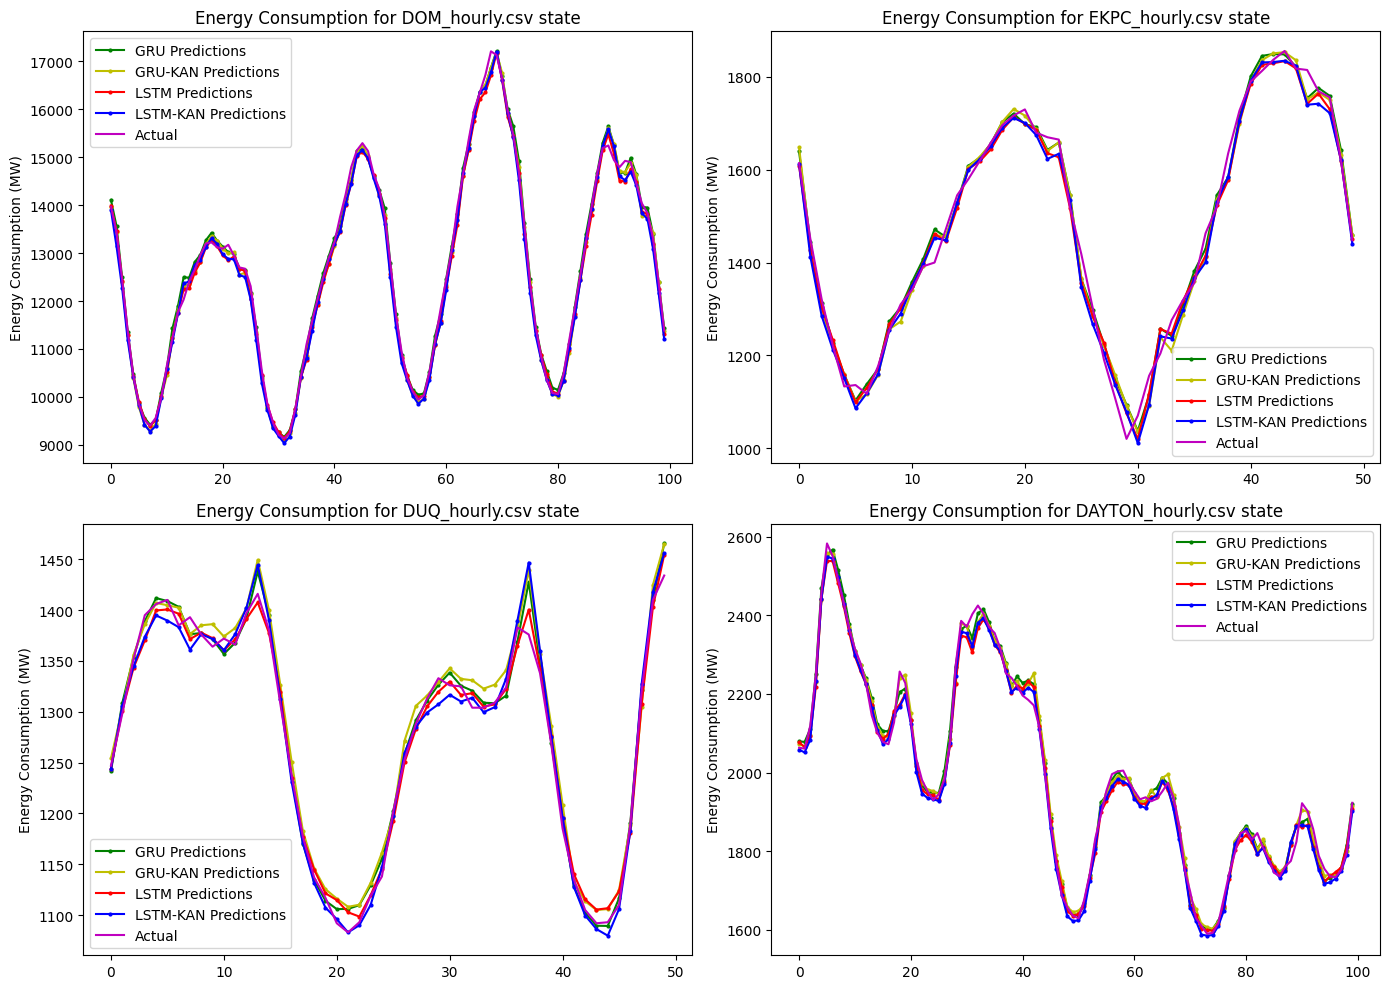

In [43]:
import matplotlib.pyplot as plt

# Warna yang akan digunakan untuk plot
colors = ["g", "y", "r", "b", "m"]

plt.figure(figsize=(14, 10))

# Subplot 1
plt.subplot(2, 2, 1)
plt.plot(gru_outputs[0][-100:], "-o", color=colors[0], label="GRU Predictions", markersize=2)
plt.plot(gru_kan_outputs[0][-100:], "-o", color=colors[1], label="GRU-KAN Predictions", markersize=2)
plt.plot(lstm_outputs[0][-100:], "-o", color=colors[2], label="LSTM Predictions", markersize=2)
plt.plot(lstm_kan_outputs[0][-100:], "-o", color=colors[3], label="LSTM-KAN Predictions", markersize=2)
plt.plot(targets[0][-100:], color=colors[4], label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[0]} state")
plt.legend()

# Subplot 2
plt.subplot(2, 2, 2)
plt.plot(gru_outputs[1][-50:], "-o", color=colors[0], label="GRU Predictions", markersize=2)
plt.plot(gru_kan_outputs[1][-50:], "-o", color=colors[1], label="GRU-KAN Predictions", markersize=2)
plt.plot(lstm_outputs[1][-50:], "-o", color=colors[2], label="LSTM Predictions", markersize=2)
plt.plot(lstm_kan_outputs[1][-50:], "-o", color=colors[3], label="LSTM-KAN Predictions", markersize=2)
plt.plot(targets[1][-50:], color=colors[4], label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[1]} state")
plt.legend()

# Subplot 3
plt.subplot(2, 2, 3)
plt.plot(gru_outputs[2][:50], "-o", color=colors[0], label="GRU Predictions", markersize=2)
plt.plot(gru_kan_outputs[2][:50], "-o", color=colors[1], label="GRU-KAN Predictions", markersize=2)
plt.plot(lstm_outputs[2][:50], "-o", color=colors[2], label="LSTM Predictions", markersize=2)
plt.plot(lstm_kan_outputs[2][:50], "-o", color=colors[3], label="LSTM-KAN Predictions", markersize=2)
plt.plot(targets[2][:50], color=colors[4], label="Actual")
plt.ylabel("Energy Consumption (MW)")
plt.title(f"Energy Consumption for {states_list[2]} state")
plt.legend()

# Subplot 4
plt.subplot(2, 2, 4)
plt.plot(gru_outputs[3][:100], "-o", color=colors[0], label="GRU Predictions", markersize=2)
plt.plot(gru_kan_outputs[3][:100], "-o", color=colors[1], label="GRU-KAN Predictions", markersize=2)
plt.plot(lstm_outputs[3][:100], "-o", color=colors[2], label="LSTM Predictions", markersize=2)
plt.plot(lstm_kan_outputs[3][:100], "-o", color=colors[3], label="LSTM-KAN Predictions", markersize=2)
plt.plot(targets[3][:100], color=colors[4], label="Actual")
plt.title(f"Energy Consumption for {states_list[3]} state")
plt.ylabel("Energy Consumption (MW)")
plt.legend()

plt.tight_layout()
plt.show()


Looks like the models are largely successful in predicting the trends of energy consumption. While they may still get some changes wrong, such as delays in predicting a drop in consumption, the predictions follow very closely to the actual line on the test set. This is due to the nature of energy consumption data and the fact that there are patterns and cyclical changes that the model can account for. Tougher time-series prediction problems such as stock price prediction or sales volume prediction may have data that is largely random or doesn’t have predictable patterns, and in such cases, the accuracy will definitely be lower.

## What's next?

* Use more data.
* Use more complex (more layers) networks.

## Thank you!

Contact Me: [Amir Masoud Sefidian](http://www.sefidian.com/) a.m.sefidian@gmail.com

Inspired from https://blog.floydhub.com/gru-with-pytorch/